In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '4'

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

import matplotlib.pyplot as plt
import cv2
from PIL import Image

import mediapy as media
import PIL
import io

import matplotlib.patches
import seaborn as sns
from IPython.display import HTML as html_print


%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('../')
sys.path.append('../core')

from raft import RAFT
from train import get_args, load_model
import datasets as raft_datasets
import teachers
import utils.flow_viz as flow_viz
import matplotlib

def segmentation_to_rgb(seg, palette=None, num_objects=None, bg_color=(0, 0, 0)):
    if num_objects is None:
        num_objects = np.max(seg)  # assume consecutive numbering
    num_objects += 1  # background
    if palette is None:
        palette = [bg_color] + sns.color_palette('hls', num_objects-1)

    seg_img = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.float32)
    for i in range(num_objects):
        seg_img[np.nonzero(seg[:, :, 0] == i)] = palette[i]
    return seg_img

def depth_to_rgb(depth, colormap=matplotlib.cm.viridis_r, sqrt=True):
    cmap = np.array(colormap.colors)
    if sqrt:
        d = np.round(np.sqrt((depth[..., 0] / 65535).clip(0, 1.)) * 255).astype(np.uint8)
    else:
        d = np.round(depth[..., 0] // 256).astype(np.uint8)
    return cmap[d]

def flow_to_rgb(vec, flow_mag_range=None, white_bg=False):
    height, width = vec.shape[:2]
    scaling = 50. / (height**2 + width**2)**0.5
    direction = (np.arctan2(vec[..., 0], vec[..., 1]) + np.pi) / (2 * np.pi)
    norm = np.linalg.norm(vec, axis=-1)
    if flow_mag_range is None:
        flow_mag_range = norm.min(), norm.max()
        magnitude = np.clip((norm - flow_mag_range[0]) * scaling, 0., 1.)
    if white_bg == True:
        value = np.ones_like(direction)
        hsv = np.stack([direction, magnitude, saturation], axis=-1)
    else:
        saturation = np.ones_like(direction)
        hsv = np.stack([direction, saturation , magnitude], axis=-1)
        rgb = matplotlib.colors.hsv_to_rgb(hsv)
    return rgb

def flow_tensor_to_rgb(flow, flow_mag_range=None, white_bg=False):
    flow_ = flow.detach().cpu().permute(1,2,0).numpy()
    flow_rgb = flow_to_rgb(flow_, flow_mag_range, white_bg)
    return torch.tensor(flow_rgb).permute(2,0,1)[None]

def set_titles(titles, axes, fontsize=20):
    assert len(titles) == len(axes)
    for i, ax in enumerate(axes):
        ax.set_title(titles[i], fontsize=fontsize)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()
    
def get_gt_boot_inputs(data, t=1):
    images, objects, flow = [data[k][None].cuda() for k in ['images', 'objects', 'flow']]
    motion = (flow[:,t].abs().sum(1, True) > 0.1).float()
    boundaries = fprop.get_mask_boundaries(
        fprop.SegmentsToAffinitiesTarget.segments_to_masks(
            objects[:,t,0]))[0].amax(1, True)
    boundaries_motion = boundaries * motion
    orientations = fprop.estimate_boundary_orientations(
        boundaries=boundaries_motion,
        energy=motion,
        radius=3,
        to_circle=False
    )
    orientations = F.normalize(orientations, dim=1, p=2) * boundaries_motion
    return (motion, boundaries_motion, orientations, flow[:,t])

def viz_gt_boot_inputs(data, t=1):
    a, b, c, f = get_gt_boot_inputs(data, t=t)
    im = data['images'][t:t+1]
    fig, axes = plt.subplots(1,5,figsize=(20,4))
    
    plots = [
        im,
        a,
        b, 
        data_utils.FlowToRgb(1.0)(c),
        flow_tensor_to_rgb(f[0])
    ]
    titles = ['image', 'motion', 'boundaries', 'orientations', 'flow']
    for i,ax in enumerate(axes):
        vis_utils.imshow(plots[i], ax)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(titles[i], fontsize=18)
        
    plt.tight_layout()
    plt.show()
    return (im, a, b, c, f)


In [4]:
import dorsalventral.models.targets as targets
import dorsalventral.vis_utils as vis_utils
import dorsalventral.data as datasets
import dorsalventral.data.utils as data_utils
import dorsalventral.models.fire_propagation as fprop
import dorsalventral.models.layer_utils as layer_utils
import dorsalventral.models.segmentation.competition as competition
import dorsalventral.models.losses as losses
import kornia

import mediapy as media
import PIL
import io

import matplotlib.patches

from IPython.display import HTML as html_print

# train local messages

In [184]:
T = 3
B = 4
ex = 1
data_dir = '/data2/honglinc/movi_d/256x256/1.0.0'
movi_dataset = datasets.movi.MoviDataset(
    dataset_dir=data_dir,
    split='train',
    passes=['images', 'objects', 'flow', 'depth'],
    sequence_length=T,
#     min_start_frame=12-(T//2),
#   max_start_frame=12-(T//2),
    min_start_frame=0,
    max_start_frame=None,
    is_test=False,
)
print(len(movi_dataset))

movi_loader = torch.utils.data.DataLoader(movi_dataset, batch_size=B, shuffle=True)


9750


In [50]:
laa_ckpts = !ls ../checkpoints/*laaStatic*

for i,ckpt in enumerate(laa_ckpts):
    print(i, ckpt)

0 ../checkpoints/10000_bbnet_laaStatic_large_seq5_0.pth
1 ../checkpoints/12500_bbnet_laaStatic_large_seq5_0.pth
2 ../checkpoints/15000_bbnet_laaStatic_large_seq5_0.pth
3 ../checkpoints/17500_bbnet_laaStatic_large_seq5_0.pth
4 ../checkpoints/20000_bbnet_laaStatic_large_seq5_0.pth
5 ../checkpoints/22500_bbnet_laaStatic_large_seq5_0.pth
6 ../checkpoints/25000_bbnet_laaStatic_large_seq5_0.pth
7 ../checkpoints/2500_bbnet_laaStatic_large_seq5_0.pth
8 ../checkpoints/27500_bbnet_laaStatic_large_seq5_0.pth
9 ../checkpoints/30000_bbnet_laaStatic_large_seq5_0.pth
10 ../checkpoints/32500_bbnet_laaStatic_large_seq5_0.pth
11 ../checkpoints/35000_bbnet_laaStatic_large_seq5_0.pth
12 ../checkpoints/37500_bbnet_laaStatic_large_seq5_0.pth
13 ../checkpoints/40000_bbnet_laaStatic_large_seq5_0.pth
14 ../checkpoints/42500_bbnet_laaStatic_large_seq5_0.pth
15 ../checkpoints/45000_bbnet_laaStatic_large_seq5_0.pth
16 ../checkpoints/47500_bbnet_laaStatic_large_seq5_0.pth
17 ../checkpoints/50000_bbnet_laaStatic_la

In [212]:
motion_ckpts = !ls ../checkpoints/*rnd1Motion*_cthr*[0].pth

for i,ckpt in enumerate(motion_ckpts):
    print(i, ckpt)

0 ../checkpoints/10000_bbnet_rnd1Motion_laaS_large_seq3_cthr075_0.pth
1 ../checkpoints/10000_bbnet_rnd1Motion_laaS_large_seq5_cthr05_0.pth
2 ../checkpoints/10000_bbnet_rnd1Motion_laaS_large_seq5_cthr075_0.pth
3 ../checkpoints/1000_bbnet_rnd1Motion_laaS_large_seq3_cthr075_0.pth
4 ../checkpoints/1000_bbnet_rnd1Motion_laaS_large_seq5_cthr05_0.pth
5 ../checkpoints/1000_bbnet_rnd1Motion_laaS_large_seq5_cthr075_0.pth
6 ../checkpoints/11000_bbnet_rnd1Motion_laaS_large_seq3_cthr075_0.pth
7 ../checkpoints/11000_bbnet_rnd1Motion_laaS_large_seq5_cthr05_0.pth
8 ../checkpoints/11000_bbnet_rnd1Motion_laaS_large_seq5_cthr075_0.pth
9 ../checkpoints/12000_bbnet_rnd1Motion_laaS_large_seq3_cthr075_0.pth
10 ../checkpoints/12000_bbnet_rnd1Motion_laaS_large_seq5_cthr05_0.pth
11 ../checkpoints/12000_bbnet_rnd1Motion_laaS_large_seq5_cthr075_0.pth
12 ../checkpoints/13000_bbnet_rnd1Motion_laaS_large_seq3_cthr075_0.pth
13 ../checkpoints/13000_bbnet_rnd1Motion_laaS_large_seq5_cthr05_0.pth
14 ../checkpoints/13000_

In [213]:
import dorsalventral.models.bbnet.pathways as pathways
import dorsalventral.models.bbnet.messages as messages
import dorsalventral.models.bbnet.utils as butils

# laa_path = '../checkpoints/30000_bbnet_laa_KLDivL_bgated_1static_r1_cthr075_bs4_0.pth'
laa_path = innate_ckpts[4]

laa_net = teachers.load_model(
    load_path=laa_path,
    model_class='affinity',
    affinity_radius=1,
    small=False,
    gate_stride=1,
    static_input=True,
    affinity_nonlinearity='none'
).cuda()

if laa_net.static_input:
    raft_wrapper = pathways.RaftPerFrameStaticWrapper
else:
    raft_wrapper = pathways.RaftPerFrameMotionWrapper

print(raft_wrapper)
LAA_net = raft_wrapper(
    net=laa_net,
    model_kwargs={'test_mode': False, 'iters': 12},
    nonlinearity='none',
    postproc_func=None
)

# apath = '../checkpoints/100000_bbnet_iMotion_1gate_cthr075_0.pth'
# apath = '../checkpoints/100000_bbnet_iMotion_1gate_cthr075_seq3_0.pth'
apath = motion_ckpts[130]

anet = teachers.load_model(
    load_path=apath,
    model_class='motion',
    small=True,
    gate_stride=1
).cuda()

Anet = pathways.RaftVideoWrapper(net=anet, 
                                model_kwargs={'test_mode': True, 'iters':24}, 
                                nonlinearity='sigmoid',
                                 postproc_func=pathways.raft_postproc,
                                stop_grad=True).cuda()
Anet.requires_grad_(False)

bnet_path = '../checkpoints/100000_bbnet_iConvGate_1gate_cthr095_bs16_0.pth'
bnet = teachers.load_model(load_path=bnet_path, 
                           model_class='conv', 
                           small=True, 
                           gate_stride=1,
#                            out_channels=32
                           out_channels=64
).cuda()
bnet.train()
bnet.requires_grad_(False)

Bnet = pathways.ConvnetPerFrameWrapper(net=bnet,
                                       postproc_func=pathways.raft_postproc,
                                       nonlinearity='sigmoid'
                                      ).cuda()

PBS = pathways.PathwayBinarySampler(num_samples=4, 
                                    thresh=0.75).cuda()

MSG = messages.LocalSpatialMessages(
    radius=laa_net.affinity_radius, 
#     affinity_nonlinearity='sigmoid', 
    affinity_nonlinearity='softmax_max',
    loss_func=butils.MaskedKLDivLoss(dim=-1),
#     loss_func=butils.MaskedBCELoss(with_logits=True),
    num_iters=1,
    store_every=None,
    mask_background=True
).cuda()


<All keys matched successfully> SpatialAffinityDecoder ../checkpoints/20000_bbnet_laaStatic_large_seq5_0.pth
functools.partial(<class 'dorsalventral.models.bbnet.pathways.NetWrapper'>, get_inputs_func=None, preproc_func=<function raft_perframe_preproc at 0x7f376dda3670>)
<All keys matched successfully> MotionClassifier ../checkpoints/53000_bbnet_rnd1Motion_laaS_large_seq3_cthr075_0.pth
<All keys matched successfully> ConvClassifier ../checkpoints/100000_bbnet_iConvGate_1gate_cthr095_bs16_0.pth


In [165]:
# import time
# print_every = 25
# num_steps = 500
# lr= 4e-4
# wd = 1e-4
# torch.autograd.set_detect_anomaly(True)

# gate_with_b = True

# def sequence_loss(logits_list, labels, valid, gamma=0.8, loss_fn=nn.BCEWithLogitsLoss(reduction='none')):
#     n_preds = len(logits_list)
#     num_px = valid.sum((-2,-1)).clamp(min=1)

#     loss = 0.0
#     for i in range(n_preds):
#         i_weight = gamma ** (n_preds - i - 1)
#         i_loss = loss_fn(logits_list[i], labels) * valid
#         i_loss = i_loss.sum((-2,-1)) / num_px
#         i_loss = i_loss.mean() * i_weight
#         loss += i_loss
#     return loss

# opt = torch.optim.AdamW(LAA_net.parameters(),
#                        lr=lr, weight_decay=wd, eps=1e-8)

# loss_curve = []
# for step in range(num_steps):
#     opt.zero_grad()

#     t1 = time.time()
#     try:
#         data = iter(movi_loader).next()
#     except StopIteration:
#         movi_loader.dataset.reset_iterator()
#         data = iter(movi_loader).next()
#     except Exception as e:
#         print("skip", step)
#         continue
        
#     x = data['images'].cuda()
#     base_frame = (x.shape[1] - 1) // 2
    
#     affinities_list = LAA_net(x)
#     a_preds = Anet(x)
#     a_target, a_mask = PBS(a_preds)

#     ## mask out pixels that you couldn't see moving anyway
#     b_preds = Bnet(x)
#     b_target, _ = PBS(b_preds)
    
#     if gate_with_b:
#         a_mask = a_mask * b_target

#     loss = 0.0
#     for i, affs in enumerate(affinities_list):
#         a_out = MSG(
#             a_target,
#             affinities=affs,
#             mask=a_mask,
#         )
#         i_loss = MSG.loss
#         i_weight = 0.8**(len(affinities_list) - i - 1)
#         i_loss = i_loss * i_weight
#         loss += i_loss
    
#     loss.backward()    
#     opt.step()
    
#     loss_curve.append(loss.item())
#     if (((step + 1) % print_every) == 0) or (step == 0):
#         print(step+1, sum(loss_curve[-print_every:]) / print_every)
        
#     t2 = time.time()


In [166]:
plt.plot(loss_curve)

NameError: name 'loss_curve' is not defined

In [167]:
# SAVE_PATH = '../checkpoints/5000_bbnet_laa_sigmoidL_r1_cthr075_bs4_0.pth'
# SAVE_PATH = '../checkpoints/25000_bbnet_laa_sigmoidL_r1_cthr075_bs4_0.pth'
# SAVE_PATH = '../checkpoints/5000_bbnet_laa_KLDivL_bgated_r1_cthr075_bs4_0.pth'
# SAVE_PATH = '../checkpoints/5000_bbnet_laa_KLDivL_bgated_0static_r1_cthr075_bs4_0.pth'
# SAVE_PATH = '../checkpoints/30000_bbnet_laa_KLDivL_bgated_1static_r1_cthr075_bs4_0.pth'

# SAVE_PATH = '../checkpoints/5000_bbnet_laa_KLDivL_seq3a_bgated_1static_r1_cthr075_bs4_0.pth'


# torch.save(laa_net.state_dict(), SAVE_PATH)

In [214]:
movi_val_dataset = datasets.movi.MoviDataset(
    dataset_dir=data_dir,
    split='validation',
    passes=['images', 'objects', 'flow', 'depth'],
    sequence_length=T,
    min_start_frame=12-(T//2),
    max_start_frame=12-(T//2),
#     min_start_frame=0,
#     max_start_frame=None,
    is_test=False,
)
print(len(movi_val_dataset))

250


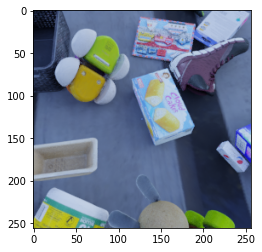

In [215]:
base_frame = 2
data = movi_val_dataset[0]
x = data['images'][None].cuda()
vis_utils.imshow(x[:,base_frame])

In [216]:
saved_tensors = torch.load('../checkpoints/motion_targets.pt')
print(saved_tensors.keys())

dict_keys(['video', 'motion_target', 'source_latent', 'loss_mask', 'student_preds'])


In [232]:
use_gt = False
use_saved = False

if use_saved:
    x = saved_tensors['video']
base_frame = (x.shape[1] - 1) // 2


PBS = pathways.PathwayBinarySampler(num_samples=4, 
                                    thresh=0.75).cuda()


affinities_list = LAA_net(x)
a_preds = Anet(x)
a_target, a_mask = PBS(a_preds)

b_preds = Bnet(x)
b_target, _ = PBS(b_preds)

a_mask = a_mask * b_target

MSG = messages.LocalSpatialMessages(
    radius=laa_net.affinity_radius, 
#     affinity_nonlinearity='none', 
    affinity_nonlinearity='softmax_max',
    loss_func=butils.MaskedKLDivLoss(dim=-1),
#     loss_func=butils.MaskedBCELoss(with_logits=True),
    num_iters=100,
    store_every=None,
    mask_background=True,
    integration_window=5,
    confidence_thresh=0.75,
    num_samples=4
).cuda()
MSG.eval()

rand_mask = (torch.rand((a_target.shape)).cuda() > 0.5).float()

if not use_gt:
    a_out = MSG(
        a_preds[-1],
#         a_target,
        affinities=affinities_list[-1],
        mask=None
#         mask=a_mask
    )

    affs = (affinities_list[-1] * 1).softmax(1)
    aff_directions = butils.spatial_moments_from_local_dist(affs)
    aff_directions_rgb = data_utils.FlowToRgb(0.25)(aff_directions) * a_preds[-1]
else:
    affs_gt = butils.get_local_neighbors(a_gt, radius=MSG.radius, to_image=True)[:,0]
    affs_gt = (affs_gt == a_gt).float() * 10    
    
    a_out = MSG(
        b_gt*rand_mask,
        affinities=affs_gt*rand_mask,
        mask=None
    )

    affs = affs_gt.softmax(1)*rand_mask
    aff_directions = butils.spatial_moments_from_local_dist(affs)
    aff_directions_rgb = data_utils.FlowToRgb(0.25)(aff_directions) * a_gt



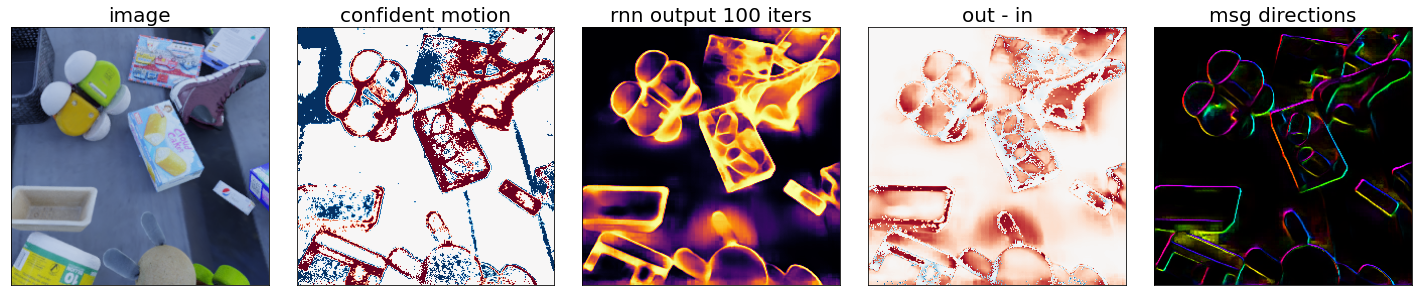

In [233]:
fig, axes = plt.subplots(1,5,figsize=(20,4))

plots = [
    x[:,base_frame],
    a_target*a_mask*2 - a_mask,
    a_out,
    a_out - a_target*a_mask,
    aff_directions_rgb
]

vis_utils.imshow(plots[0], axes[0])
vis_utils.imshow(plots[1], axes[1], cmap='RdBu_r', vmin=-1, vmax=1)
vis_utils.imshow(plots[2], axes[2], cmap='inferno', vmin=0, vmax=1)
vis_utils.imshow(plots[3], axes[3], cmap='RdBu_r', vmin=-1, vmax=1)
vis_utils.imshow(plots[4], axes[4])

titles = ['image', 'confident motion', 'rnn output %d iters' % MSG.num_iters, 'out - in', 'msg directions']
set_titles(titles, axes)
plt.show()

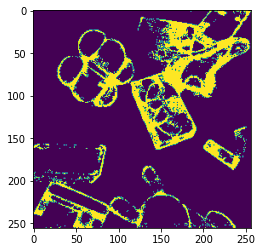

In [219]:
vis_utils.imshow(a_target*a_mask)

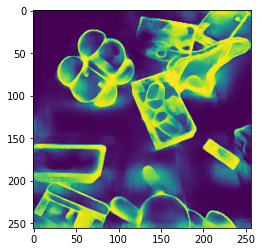

In [227]:
vis_utils.imshow(a_preds[0])

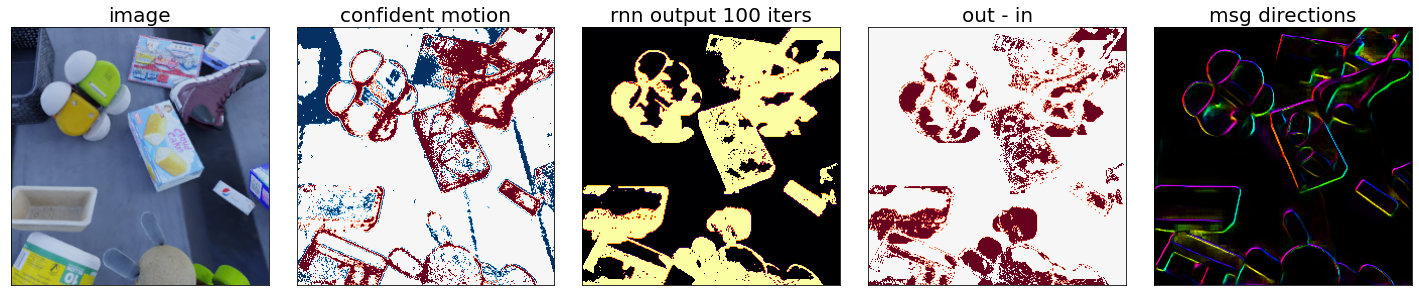

In [210]:
fig, axes = plt.subplots(1,5,figsize=(20,4))

plots = [
    x[:,base_frame],
    a_target*a_mask*2 - a_mask,
    a_out,
    a_out - a_target*a_mask,
    aff_directions_rgb
]

vis_utils.imshow(plots[0], axes[0])
vis_utils.imshow(plots[1], axes[1], cmap='RdBu_r', vmin=-1, vmax=1)
vis_utils.imshow(plots[2], axes[2], cmap='inferno', vmin=0, vmax=1)
vis_utils.imshow(plots[3], axes[3], cmap='RdBu_r', vmin=-1, vmax=1)
vis_utils.imshow(plots[4], axes[4])

titles = ['image', 'confident motion', 'rnn output %d iters' % MSG.num_iters, 'out - in', 'msg directions']
set_titles(titles, axes)
plt.show()

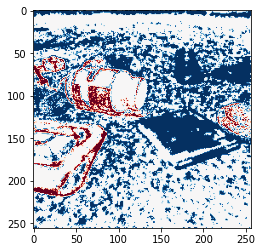

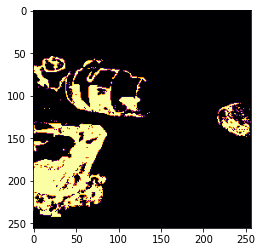

In [211]:
vis_utils.imshow(saved_tensors['source_latent']*saved_tensors['loss_mask']*2 - saved_tensors['loss_mask'],
                 cmap='RdBu_r', vmin=-1, vmax=1)
vis_utils.imshow(saved_tensors['motion_target'], cmap='inferno', vmin=0, vmax=1)

# vis_utils.imshow(saved_tensors['loss_mask'])

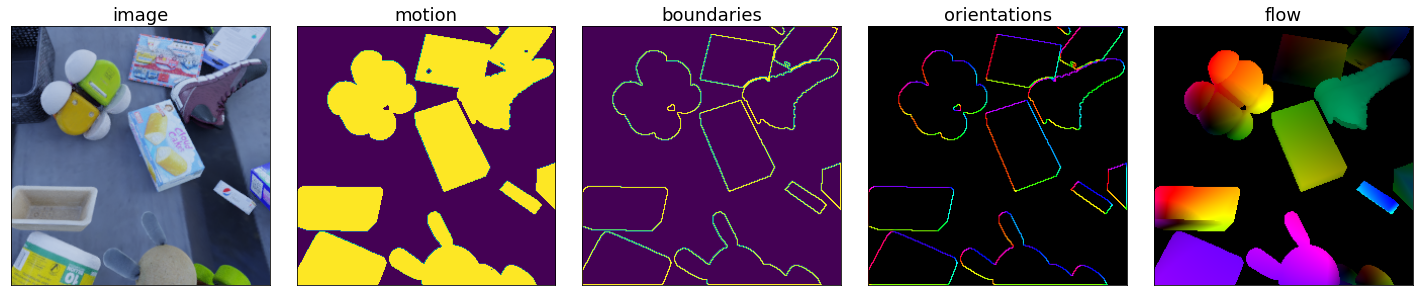

In [32]:
im, a_gt, b_gt, c_gt, f_gt = viz_gt_boot_inputs(data, t=2)

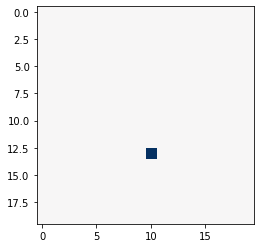

In [14]:
vis_utils.imshow(
    (a_target*a_mask*2 - a_mask)[:,:,50:70,30:50],
    cmap='RdBu_r', vmin=-1, vmax=1
)

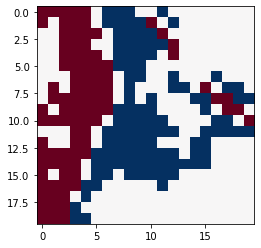

In [15]:
vis_utils.imshow(
    (a_target*a_mask*2 - a_mask)[:,:,100:120,110:130],
    cmap='RdBu_r', vmin=-1, vmax=1
)